# Deep Residual Network 

- DNN have a problem when training and it is that of the vanishing gradient in the shallow layers 
- the nn params are updated by backprop from the output to all previous layers
- deeper layers do get trained, but numbers become smaller and smaller, and when the algo gets to the shallower layers, the gradient is so small, it has no effect. 

### Resnet
- to solve the problem , the concept of deep residual learning was introduced. Attributed to MSFT <3
- instead of passing through all layers, the backprop skips scertain layers and allows it to pass to shallower layers through a "shortcut" connection. 

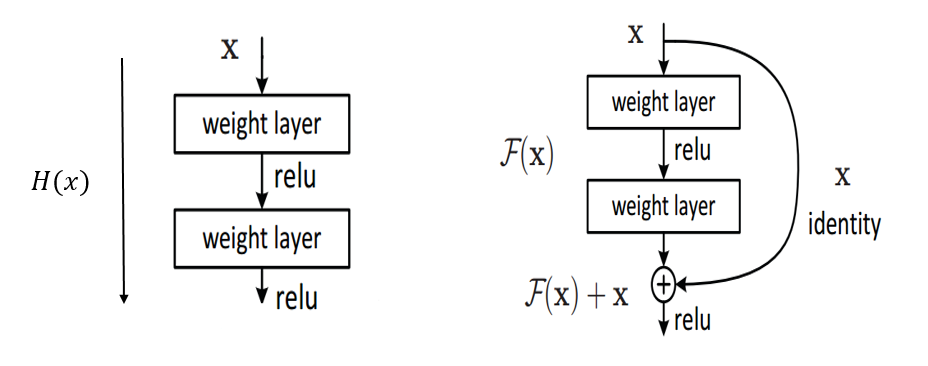


# ACTUAL RESNET ARCHITECTURE
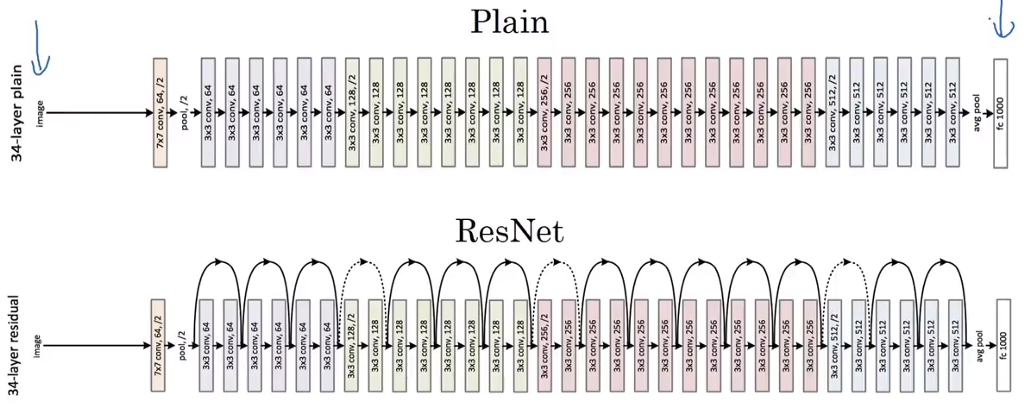

### Let's build our own Resnet  to classify the CIFAR10 Dataset

In [1]:
# libraries

# data
import numpy as np

# Viz
import matplotlib.pyplot as plt

# keras layers and model 
from keras.layers import Dense, BatchNormalization, Input, Activation, Conv2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model

# datasets and transformations
from keras.datasets import cifar10
from keras.utils import to_categorical



Using TensorFlow backend.


In [4]:
# data 

(x_train,y_train), (x_test,y_test) = cifar10.load_data()
print("Training data shape: {}, labels {}".format(x_train.shape,y_train.shape))
print("Testing data shape: {}, labels {}".format(x_test.shape,y_test.shape))

Training data shape: (50000, 32, 32, 3), labels (50000, 1)
Testing data shape: (10000, 32, 32, 3), labels (10000, 1)


In [5]:
label_dict = {0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

C:\Users\mjcastaneda4\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


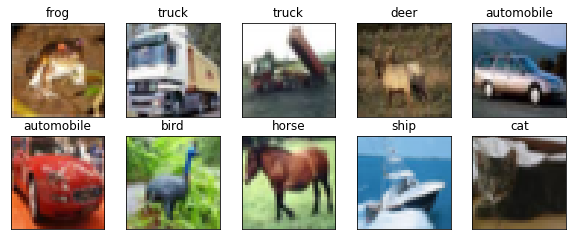

In [4]:
plt.figure(figsize=(10,10))
for idx,i in enumerate(range(10)):
    plt.subplot(5,5,idx+1)
    plt.imshow(x_train[i])
    plt.title(label_dict[int(y_train[i])])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

plt.show()

#### The ResNet Architecture 
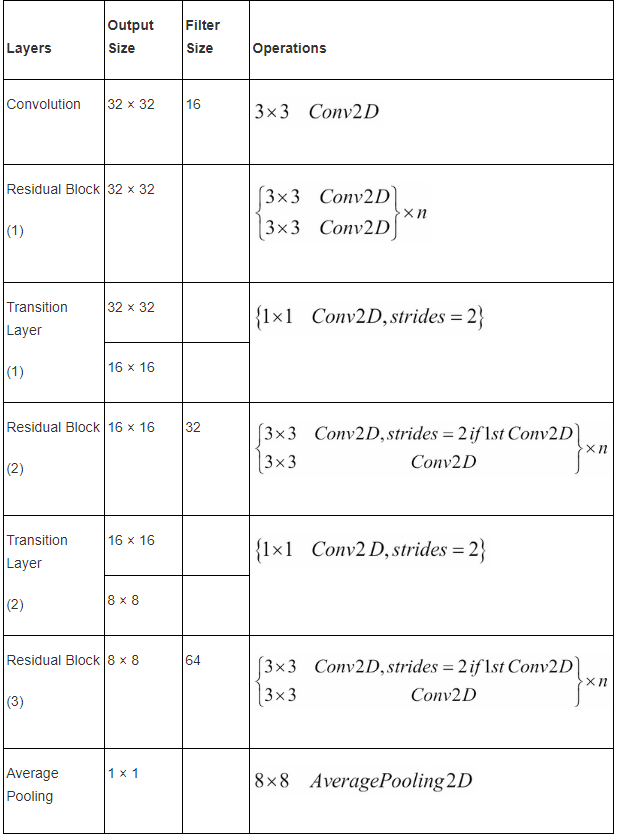

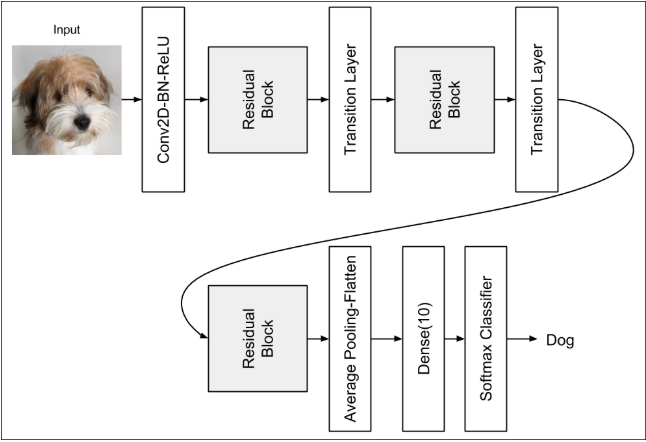

In [2]:
# Network Training Params 
batch_size = 128
epochs = 200
data_augmentation = True
num_classes = 10

# substract pixel mean improves acc
substract_pixel_mean = True

# V1 vs V2

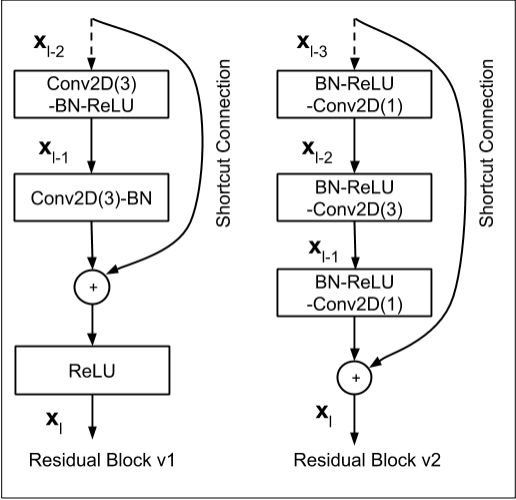

In [3]:
# ResNet20 = 3 = 2n = 2(3) = 6 depth
# training V1 of the resnet in which blocks are
# Conv2d(3)-bn-relu --> Conv2d(3)-bn --> transition then --> RELU 
# each st has 2n layers corresponding to n residual blocks
# this one will have a 3n - 3 residual blocks 

# number of residual blocks
n = 3

# model version 
version = 1 

# depth according to version 

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
# model type

model_type = "ResNet{}v{}".format(depth,version)
print(model_type)

ResNet20v1


In [6]:
# image dimensions 

input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [8]:
# normalize data 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if substract pixel is true
if substract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
    
print('x_train shape:{}'.format(x_train.shape))
print('x_test shape:{}'.format(x_test.shape))
print('y_train shape:{}'.format(y_train.shape))

x_train shape:(50000, 32, 32, 3)
x_test shape:(10000, 32, 32, 3)
y_train shape:(50000, 1)


In [9]:
y_train[0]

array([6], dtype=uint8)

In [10]:
# convert class vectors to bin class matrix
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

y_train.shape

(50000, 10)

In [11]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [12]:
y_test.shape

(10000, 10)

###### The learning rate schedule
- the lr is scheduled to be reduced after 80, 120, 160, and 180 epochs
- the lr is reduced to make jumps smaller and avoid the algo from skipping the local minima and allow it to continue reducing the error 

- Args:
    - epoch
- Returns:
    - lr: learning rate

In [7]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print("Learning Rate {}".format(lr))
    return lr

In [8]:
epochs_try = [81,121,161,181]
for i in epochs_try:
    lr_schedule(i)

Learning Rate 0.0001
Learning Rate 1e-05
Learning Rate 1e-06
Learning Rate 5e-07


##### THE RESNET LAYER

- Architecture:
    - 2D Conv - Batch-Normalization - Activation
    - conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
- Initializers 
    - Initializations define the way to set the initial random weights of Keras layers.
    - he_normal He normal initializer draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
    

In [9]:
def resnet_layer(inputs, num_filters=16,kernel_size=3,
                 strides=1,activation='relu',
                 batch_normalization=True,conv_first=True):
    conv = Conv2D(num_filters,kernel_size=kernel_size,
                 strides=strides,
                 padding='same',
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        elif activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
        

### the resnet network V1
- Architecture:
    - stacks of 2 x (3x3) Conv2d - bn - relu
    - the transition layer (1x1 conv2d)
    - last relu is after the residual block (relu)
    Each stage:
    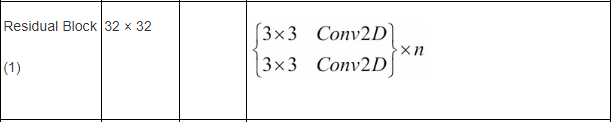
    - last relu is after the residual block
    - fmp is halved by the stride 2 conv, while the number of filters increases
    - fmp sizes:
        - stage 0: 32x32 px, 16 filters
        - stage 1: 16x16 px, 32 filters
        - stage 2: 8x8 px, 64 filters
        

In [10]:
def resnetv1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise(ValueError('depth should be 6n+2 (20, 32, 44, in [a])'))
    
    # model definition 
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    # INPUT SHAPE = (32,32,3) (PX,PX,CHANNELS)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # Create 3 residual units
    # a stack is a 2 x (3x3) (conv2d) like in picture with bn and activation
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0: # first layer but not first stack
                strides = 2 # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0: # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dimensions
                # 1x1 covn2d with stride = 2
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            x = add([x,y])
            x = Activation('relu')(x)
            
        num_filters *= 2
        
    # Add classifier on top
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    
    model = Model(inputs=inputs,outputs=outputs)
    
    return model
            
            

In [11]:
# model 
model = resnetv1(input_shape=input_shape,depth=depth)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()

Learning Rate 0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

In [12]:
# filepath to save model
file = "w-acc-{epoch:02d}-{acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file,monitor='val_acc', verbose=1, save_best_only=True,mode='max')
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                              cooldown=0,
                              patience=5,
                              min_lr=0.5e-6)
callback = [checkpoint,lr_reducer,lr_scheduler]



In [14]:
model.load_weights('w-acc-86-0.9999.hdf5')
model.save('resnet_classifier.h5')

In [13]:
#model.fit(x_train,y_train,batch_size=batch_size,
#          epochs=200, validation_data=(x_test, y_test),shuffle=True,callbacks=callback)

model.load_weights('w-acc-86-0.9999.hdf5')

scores = model.evaluate(x_test,y_test,verbose=1)
print('loss = {}'.format(scores[0]))
print('acc = {}'.format(scores[1]))

ValueError: Error when checking target: expected dense_1 to have shape (10,) but got array with shape (1,)

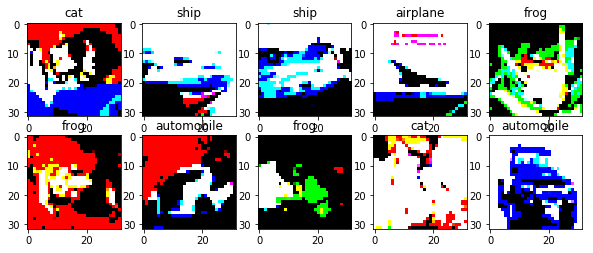

In [46]:
plt.figure(figsize=(10,10))
for idx,i in enumerate(range(10)):
    plt.subplot(5,5,idx+1)
    plt.imshow(x_test[i] * 255)
    plt.title(label_dict[np.argmax(model.predict(x_test[i,...].reshape(1,32,32,3)))])
    
plt.show()